In [ ]:
# !pip install transformers
!pip install --no-cache-dir transformers sentencepiece
import json
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModel, AutoModelForSeq2SeqLM
import torch
from collections import defaultdict
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from scipy import spatial
from matplotlib.pyplot import figure

import nltk
nltk.download('punkt')

     |████████████████████████████████| 4.0 MB 19.1 MB/s 
     |████████████████████████████████| 1.2 MB 53.0 MB/s 
     |████████████████████████████████| 6.6 MB 42.0 MB/s 
     |████████████████████████████████| 895 kB 56.5 MB/s 
     |████████████████████████████████| 77 kB 54.2 MB/s 
     |████████████████████████████████| 596 kB 20.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open("/content/drive/MyDrive/tydiqa/data/tydiqa-goldp-v1.1-train.json") as f:
  train_data = json.load(f)
  print(train_data.keys())

dict_keys(['data', 'version'])


###Peek into data

In [ ]:
train_data['data'][:5]

[{'paragraphs': [{'context': 'Charles Hoy Fort (6. elokuuta (joidenkin lähteiden mukaan 9.) 1874 – 3. toukokuuta 1932) oli yhdysvaltalainen kirjailija ja paranormaalien ilmiöiden tutkija.',
    'qas': [{'answers': [{'answer_start': 18,
        'text': '6. elokuuta (joidenkin lähteiden mukaan 9.) 1874'}],
      'id': 'finnish--7633091408814529542-0',
      'question': 'Milloin Charles Fort syntyi?'}]}],
  'title': 'Charles Fort'},
 {'paragraphs': [{'context': '   Altruismi ([1],  ”toinen”[2]) tarkoittaa epäitsekästä ja pyyteetöntä[3] [4] toimintaa, jossa toisen hyvä asetetaan oman edun edelle.[5] Altruismin vastakohta on egoismi.[6] Termin esitti ranskalainen filosofi Auguste Comte vuonna 1851, jolloin hän määritteli altruismin uhrautumiseksi muiden eduksi.[1]',
    'qas': [{'answers': [{'answer_start': 44,
        'text': 'epäitsekästä ja pyyteetöntä[3] [4] toimintaa, jossa toisen hyvä asetetaan oman edun edelle'}],
      'id': 'finnish-8742325368463988542-0',
      'question': 'Mitä o

In [ ]:
train_data['data'][-5:]

[{'paragraphs': [{'context': 'মুহাম্মাদ মুরসি ইসা আল-আইয়াত (Egyptian Arabic: محمد مرسى عيسى العياط\u200e, IPA:[mæˈħammæd ˈmʊɾsi ˈʕiːsæ l.ʕɑjˈjɑːtˤ], জন্মঃ ২০ অগাস্ট, ১৯৫১) একজন মিশরীয় রাজনীতিবিদ, প্রকৌশলী এবং মিশরের বর্তমান ও পঞ্চম রাষ্ট্রপতি।।[1]',
    'qas': [{'answers': [{'answer_start': 121, 'text': '২০ অগাস্ট, ১৯৫১'}],
      'id': 'bengali--1108486140398659321-0',
      'question': 'মুহাম্মাদ মুরসি ইসা আল-আইয়াত কবে জন্মগ্রহণ করেন ?'}]}],
  'title': 'মুহাম্মাদ মুরসি'},
 {'paragraphs': [{'context': 'আনুমানিক ৫৭০ খ্রিস্টাব্দে (হস্তিবর্ষ) মক্কা নগরীতে জন্ম নেওয়া মুহাম্মাদ মাতৃগর্বে থাকাকালীন পিতা হারা হন শিশু বয়সে মাতাকে হারিয়ে এতিম হন এবং প্রথমে তাঁর পিতামহ আবদুল মোত্তালিব ও পরে পিতৃব্য আবু তালিবের নিকট লালিত পালিত হন। হেরা পর্বতের গুহায় ধ্যানমগ্ন থাকার পর ৪০ বছর বয়সে তিনি নবুওয়াত লাভ করেন। জিবরাইল এই পর্বতের গুহায় আল্লাহর তরফ থেকে তাঁর নিকট ওহী নিয়ে আসেন।[16] তিন বছর পর ৬১০ খ্রিস্টাব্দে[17] মুহাম্মাদ প্রকাশ্যে ওহী প্রচার করেন,[18] এবং ঘোষণা দেন "আল্লাহ এক" ও তাঁর নিকট নিজ

In [ ]:
len(train_data['data'])

49881

In [ ]:
from collections import defaultdict

lang_to_count = defaultdict(int)
for datum in train_data['data']:
  for para in datum['paragraphs']:
    for qa in para['qas']:
      lang = qa['id'].split("-")[0]
      lang_to_count[lang] += 1
print(lang_to_count)

defaultdict(<class 'int'>, {'finnish': 6855, 'telugu': 5563, 'russian': 6490, 'arabic': 14805, 'indonesian': 5702, 'english': 3696, 'swahili': 2755, 'korean': 1625, 'bengali': 2390})


###XLM Roberta Embeddings

In [ ]:
train_data['data'][0]['paragraphs'][0]['qas'][0]['id']

'finnish--7633091408814529542-0'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
model = AutoModelForMaskedLM.from_pretrained("xlm-roberta-base")

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

In [ ]:
for idx, datum in enumerate(train_data['data']):
  for para in datum['paragraphs']:
    for qa in para['qas']:
      question = qa['question']
      encoded_input = tokenizer(question, return_tensors='pt')
      output = model(**encoded_input)

  if idx == 2:
    break

In [ ]:
output.logits.shape

torch.Size([1, 11, 250002])

In [ ]:
encoded_input

{'input_ids': tensor([[     0,  83113,   1194,  96513, 142092, 203217,  24943,   2601,  14907,
             32,      2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

###Sentence Embeddings

In [ ]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


In [ ]:
sentences = ['This is an example sentence', 'Each sentence is converted']

# Load model from HuggingFace Hub
# tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens')
# model = AutoModel.from_pretrained('sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens')
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/distiluse-base-multilingual-cased-v2')
model = AutoModel.from_pretrained('sentence-transformers/distiluse-base-multilingual-cased-v2')

# Tokenize sentences
encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

# Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

# Perform pooling. In this case, max pooling.
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

print("Sentence embeddings:")
print(sentence_embeddings)


Downloading:   0%|          | 0.00/531 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/610 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/514M [00:00<?, ?B/s]

Sentence embeddings:
tensor([[ 0.0789,  0.0301, -0.1049,  ...,  0.0582,  0.0896, -0.0407],
        [ 0.0042,  0.0390, -0.0065,  ...,  0.0326, -0.0006, -0.0060]])


In [ ]:
sentence_embeddings.shape

torch.Size([2, 768])

In [ ]:
questions = defaultdict(list)
for datum in train_data['data']:
  for para in datum['paragraphs']:
    for qa in para['qas']:
      lang = qa['id'].split("-")[0]
      if lang == "english":
        questions["en"].append(qa['question'])
      elif lang == "arabic":
        questions["ar"].append(qa['question'])

In [ ]:
for q in questions:
  print(q, len(questions[q]))

ar 14805
en 3696


In [ ]:
sent_embed = defaultdict(list)
for lang, sentences in questions.items():
  sentences = sentences[:500]
  encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

  # Compute token embeddings
  with torch.no_grad():
      model_output = model(**encoded_input)

  # Perform pooling. In this case, max pooling.
  sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
  sent_embed[lang] = sentence_embeddings

In [ ]:
X = np.array([emb.tolist() for emb in sent_embed['en']] + [emb.tolist() for emb in sent_embed['ar']] )
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X)
y = np.array([0 for i in range(len(sent_embed['en']))] + [1 for i in range(len(sent_embed['en']))])

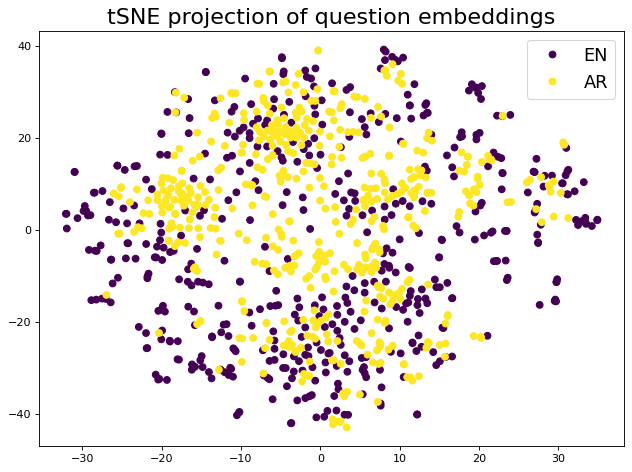

In [ ]:
figure(figsize=(8, 6), dpi=80)
scatter = plt.scatter(X_embedded[:,0], X_embedded[:,1], c=y)
handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, ["EN", "AR"], fontsize=16)
plt.title("tSNE projection of question embeddings", fontsize=20)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/tydiqa/fig/en_ar_tsne_distiluse.pdf')

In [ ]:
candidate_pairs = []
cos_result = np.zeros((len(sent_embed['en']), len(sent_embed['ar'])))
for en_idx, en_emb in enumerate(sent_embed['en']):
  for ar_idx, ar_emb in enumerate(sent_embed['ar']):
    cos_sim = 1 - spatial.distance.cosine(en_emb, ar_emb)
    cos_result[en_idx, ar_idx] = cos_sim
    candidate_pairs.append((en_idx, ar_idx, cos_sim))

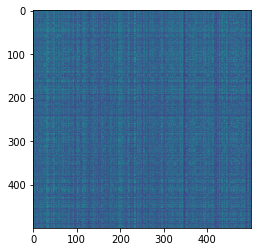

In [ ]:
plt.imshow(cos_result)

In [ ]:
len(candidate_pairs), np.mean(np.abs(cos_result))

(250000, 0.2562303729302852)

In [ ]:
for en_idx, ar_idx, cos_sim in candidate_pairs:
  print(questions['en'][en_idx], questions['ar'][ar_idx], cos_sim)
  break

When was quantum field theory developed? ما هي المسألة الشرقية ؟ 0.10193014144897461


In [ ]:
import csv  

header = ['en_question', 'ar_question', 'cos_sim']
data = [[questions['en'][e], questions['ar'][a],c] for e, a, c in candidate_pairs]

with open('/content/drive/MyDrive/tydiqa/en_ar_sim_pairs_distiluse_0419.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)

    # write the data
    writer.writerows(data)


In [ ]:
data[0]

['When was quantum field theory developed?',
 'ما هي المسألة الشرقية ؟',
 0.10193014144897461]

In [ ]:
count = 0
for e, a, c in candidate_pairs:
  if c > 0.5:
    count += 1

count

4004

###Translation

In [ ]:
ar2en_tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-ar-en")
ar2en_model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-ar-en")
# ar2en_model = ar2en_model.to('cuda')

Downloading:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/896k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/783k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.03M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/293M [00:00<?, ?B/s]

In [ ]:
print(ar2en_tokenizer)

PreTrainedTokenizer(name_or_path='Helsinki-NLP/opus-mt-ar-en', vocab_size=62834, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'})


In [ ]:
all_src_text = questions['ar'][:500]
translated = []
i = 0
while i <= 450:
  src_text = all_src_text[i:i+50]
  encoded_input = ar2en_tokenizer(src_text, padding=True, truncation=True, return_tensors='pt') #.to('cuda')
  print(encoded_input)
  # with ar2en_tokenizer.as_target_tokenizer():
  #   labels = ar2en_tokenizer(tgt_texts, ...)
  with torch.no_grad():
      model_output = ar2en_model.generate(**encoded_input)
  # translated = [tokenizer.decode(t, skip_special_tokens=True) for t in model_output]
  out = ar2en_tokenizer.batch_decode(model_output, skip_special_tokens=True)
  translated.extend(out)
  i += 50

# model_inputs = tokenizer(src_texts, ...)
# with tokenizer.as_target_tokenizer():
#     labels = tokenizer(tgt_texts, ...)
# model_inputs["labels"] = labels["input_ids"]

{'input_ids': tensor([[   62,   220,  1605,  ..., 62833, 62833, 62833],
        [ 1706,   102,  6239,  ..., 62833, 62833, 62833],
        [ 3777, 16210,  8734,  ..., 62833, 62833, 62833],
        ...,
        [   11, 17837,   234,  ..., 62833, 62833, 62833],
        [ 3777,    23, 47318,  ..., 62833, 62833, 62833],
        [   11,   164, 26837,  ..., 62833, 62833, 62833]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}
{'input_ids': tensor([[    9,   136,   166,  ..., 62833, 62833, 62833],
        [   62,    36,    41,  ..., 62833, 62833, 62833],
        [ 1706, 10307,    40,  ..., 62833, 62833, 62833],
        ...,
        [  136, 24654,  8005,  ..., 14809,    55,     0],
        [   62,    36,   134,  ..., 62833, 62833, 62833],
        [ 1706,   449,   793,  ..., 62833, 62833, 62833]]), 'attentio

In [ ]:
len(src_text), len(translated)

(50, 500)

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu
reference = [['this', 'is', 'a', 'test'], ['this', 'is' 'test']]
candidate = ['this', 'is', 'a', 'test']
score = sentence_bleu(reference, candidate)
print(score)

1.0


In [ ]:
import csv
from nltk.translate.bleu_score import SmoothingFunction  

header = ['en_question', 'ar_question', 'ar_to_en', 'cos_sim', 'bleu']
# data = [[questions['en'][e], questions['ar'][a],c] for e, a, c in candidate_pairs]
data = []
for e, a, cos_sim in candidate_pairs:
  en_question = questions['en'][e]
  ar_question = questions['ar'][a]

  ref = word_tokenize(en_question)
  tra = word_tokenize(translated[a])
  bleu = sentence_bleu(ref, tra, smoothing_function=SmoothingFunction().method1)
  data.append([en_question, ar_question, translated[a], cos_sim, bleu])
  

with open('/content/drive/MyDrive/tydiqa/en_ar_sim_pairs_distiluse_0419.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)

    # write the data
    writer.writerows(data)


In [ ]:
cos_sim_arr = []
bleu_arr = []
for datum in data:
  cos_sim_arr.append(datum[3])
  bleu_arr.append(datum[4])

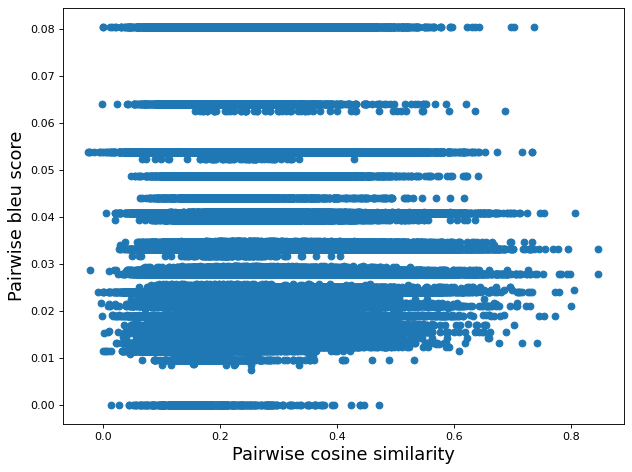

In [ ]:
figure(figsize=(8, 6), dpi=80)
plt.scatter(cos_sim_arr, bleu_arr)
plt.xlabel("Pairwise cosine similarity", fontsize=16)
plt.ylabel("Pairwise bleu score", fontsize=16)
# plt.title("tSNE projection of question embeddings", fontsize=20)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/tydiqa/fig/ar_en_scatter_cos_vs_bleu_distiluse.pdf')

In [ ]:
for datum in data:
  if datum[3] > 0.7:
    print("{}\t{}\t{}".format(datum[0], datum[2], datum[1]))

How many people died during WW1?	How many countries have participated in the Second World War?	كم عدد الدول التي شاركت في الحرب العالمية الثانية؟
When was the Nazi party founded?	What year was the Nazi party founded?	في أي عام تأسس الحزب النازي؟
How many people live in china?	What is the population of the Republic of China?	ماهو تعداد سكان جمهورية الصين ؟
What is the most common type of desert?	Where is the largest desert in the world?	اين تقع اكبر صحراء في العالم ؟
What is the most common type of desert?	What is the largest desert in Saudi Arabia?	ما هي اكبر صحراء في السعودية ؟
What is the newest member country to join NATO?	How many states does NATO have?	كم دولة يضم تحالف الناتو؟
When was the University of Maryland football team established?	When was the FIFA World Cup founded?	متى تأسس إتحاد كأس العالم لكرة القدم ؟
When was the University of Maryland football team established?	When was Edinburgh founded?	متى تأسست جامعة إدنبرة؟
How long is the Omo River?	How long is the cash river?